In [105]:
import sqlite3

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

sns.set_style("darkgrid")
float_formatter = "{:.5}".format
np.set_printoptions(formatter={"float_kind": float_formatter})

### Load Data from the database


In [106]:
def dict_factory(cursor, row):
    col_names = [col[0] for col in cursor.description]
    return {key: value for key, value in zip(col_names, row)}


query1 = """
    SELECT
        g.result,
        --g.start_time + 40 * g.increment as total_time,
        g.increment,
        g.start_time,
        g.url,
        p.eval,
        p.ply,
        g.elo_white - g.elo_black as elo_dif,
        1 as weight
    FROM
        games g INNER JOIN positions p
        ON g.rowid = p.game_id
    WHERE
        g.result != 0
        AND p.eval is not NULL
    """

with sqlite3.connect("games.sqlite") as con:
    con.row_factory = dict_factory
    res = con.execute(query1)
    data = pd.DataFrame(res)

con.close()

### Weight moves by number of moves in each game


In [107]:
g = data.groupby("url").count()
data2 = data.merge(g.result, on="url", suffixes=("", "_y"))
data2.weight = data2.weight / data2.result_y

### Define the steps in the analysis pipeline


In [183]:
random_state = 42

features = [
    "eval",
    # "ply",
    # "elo_dif",
    # "start_time",
    # "increment",
    # "total_time"
]

X = data2[features]
y = data2.result
weights = data2.weight * 114244 / 1505

X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(
    X, y, weights, random_state=random_state, stratify=y
)

scaler = StandardScaler(
    with_mean=False,
)

classifier = LogisticRegressionCV(
    max_iter=200,
    Cs=15,
    # Cs=[1],
    random_state=random_state,
    n_jobs=-1,
    penalty="elasticnet",
    solver="saga",
    l1_ratios=np.linspace(0, 1, num=10),
    # fit_intercept=False,
    # class_weight="balanced",
)

model = Pipeline(
    steps=[
        # ("scaler", scaler),
        ("classifier", classifier),
    ]
)

model.fit(
    X_train,
    y_train,
    # scaler__sample_weight=weights_train,
    classifier__sample_weight=weights_train,
)

d:\programme\miniconda\envs\manim-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1861: UserWarning: l1_ratios parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


Pipeline(steps=[('classifier',
                 LogisticRegressionCV(Cs=15,
                                      l1_ratios=array([0.0, 0.11111, 0.22222, 0.33333, 0.44444, 0.55556, 0.66667, 0.77778,
       0.88889, 1.0]),
                                      max_iter=200, n_jobs=-1, random_state=42,
                                      solver='saga'))])

### Show resulting coefficients


In [194]:
print(f"Accuracy: \n {model.score(X_test, y_test, sample_weight=weights_test)}")
# scale = model.named_steps["scaler"].scale_
# mean = model.named_steps["scaler"].mean_
# print(f"Mean: \n {mean}")

scale = 1

coefs = model.named_steps["classifier"].coef_ / scale
print(f"Coefficients: \n {coefs}")

intercept = model.named_steps["classifier"].intercept_
print(f"Intercept: \n {intercept}")

cs = model.named_steps["classifier"].C_
print(f"Regularization strenght: \n {cs}")

l1_ratio = model.named_steps["classifier"].l1_ratio_
print(f"L1 Ratio: {l1_ratio}")

Accuracy: 
 0.6827549980571913
Coefficients: 
 [[0.0032662]]
Intercept: 
 [-8.4221e-05]
Regularization strenght: 
 [0.0001]
L1 Ratio: [None]


### Show results


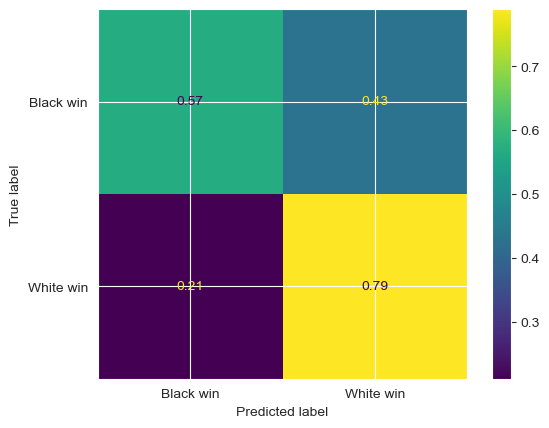

In [185]:
ConfusionMatrixDisplay.from_estimator(
    model,
    X_test,
    y_test,
    sample_weight=weights_test,
    normalize="true",
    display_labels=[
        "Black win",
        # "Draw",
        "White win",
    ],
)

# plt.savefig("images\\tmp\\confusion_matrix_with_elo.png", dpi=300, facecolor="white")

### Plots


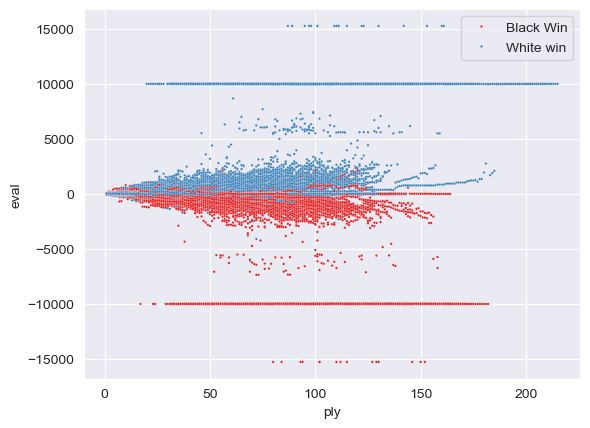

In [186]:
pd.set_option("mode.chained_assignment", None)

data_plot = data[["eval", "ply", "elo_dif", "result", "increment", "start_time"]]
data_plot.loc[:, "result"] = (data_plot.loc[:, "result"] + 1).copy() / 2

g = sns.scatterplot(
    data_plot,
    x="ply",
    y="eval",
    hue="result",
    s=3,
    palette="Set1",
)
legend = [
    "Black Win",
    # "Draw",
    "White win",
]
handles, labels = g.get_legend_handles_labels()
g.legend(handles, legend)

# plt.savefig("images\\tmp\\ply_eval.png", dpi=300, facecolor="white")

<Axes: xlabel='eval', ylabel='Chance'>

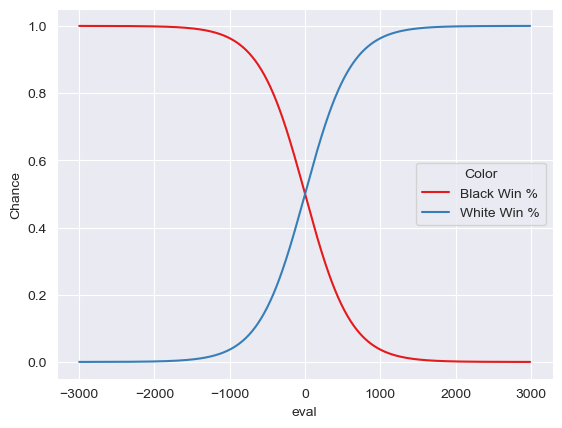

In [187]:
cps = pd.DataFrame(np.arange(-3000, 3000, 10), columns=["eval"])
pred = pd.DataFrame(
    model.predict_proba(cps),
    columns=[
        "Black Win %",
        # "Draw %",
        "White Win %",
    ],
)
data_plot = pd.concat([cps, pred], axis=1)

df_melted = data_plot.melt("eval", var_name="Color", value_name="Chance")

sns.lineplot(data=df_melted, x="eval", y="Chance", hue="Color", palette="Set1")
# plt.savefig("images\\tmp\\eval_winchance.png", dpi=300, facecolor="white")

In [192]:
model.predict_proba(np.arange(0, 1000, 50).reshape(-1,1))

d:\programme\miniconda\envs\manim-env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegressionCV was fitted with feature names
  warnings.warn(


array([[0.50002, 0.49998],
       [0.45928, 0.54072],
       [0.41908, 0.58092],
       [0.37993, 0.62007],
       [0.34228, 0.65772],
       [0.30652, 0.69348],
       [0.27294, 0.72706],
       [0.24176, 0.75824],
       [0.21309, 0.78691],
       [0.18699, 0.81301],
       [0.16342, 0.83658],
       [0.1423, 0.8577],
       [0.12351, 0.87649],
       [0.10689, 0.89311],
       [0.092269, 0.90773],
       [0.079472, 0.92053],
       [0.068316, 0.93168],
       [0.058626, 0.94137],
       [0.050236, 0.94976],
       [0.042993, 0.95701]])